In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GRU, Concatenate, Dropout, Lambda
import tensorflow.keras.backend as K

In [2]:
# 중력 가속도 (m/s²)
GRAVITY = 9.81  

# Inertial Signals 데이터 로드 함수
def load_inertial_train_data():
    """
    UCI HAR Inertial Signals 데이터를 로드하는 함수.
    
    출력:
        X_df (DataFrame): 가속도 데이터 (X, Y, Z)
        y_df (DataFrame): 활동 라벨
    """
    data_dir = "E:/AI/UCI_HAR/train/Inertial Signals/"

    # Inertial Signals 가속도 데이터 로드
    acc_x = np.loadtxt(os.path.join(data_dir, "body_acc_x_train.txt"))
    acc_y = np.loadtxt(os.path.join(data_dir, "body_acc_y_train.txt"))
    acc_z = np.loadtxt(os.path.join(data_dir, "body_acc_z_train.txt"))

    # 활동 라벨 로드
    y_path = "E:/AI/UCI_HAR/train/y_train.txt"
    y_train = pd.read_csv(y_path, delim_whitespace=True, header=None, names=["Activity"])

    # 각 샘플의 평균 가속도 값 사용 (샘플당 128개의 시퀀스 값 존재)
    X_train = pd.DataFrame({
        "ax": np.mean(acc_x, axis=1),
        "ay": np.mean(acc_y, axis=1),
        "az": np.mean(acc_z, axis=1),
    })

    return X_train, y_train

def load_inertial_test_data():
    """
    UCI HAR Inertial Signals 데이터를 로드하는 함수.
    
    출력:
        X_df (DataFrame): 가속도 데이터 (X, Y, Z)
        y_df (DataFrame): 활동 라벨
    """
    data_dir = "E:/AI/UCI_HAR/test/Inertial Signals/"

    # Inertial Signals 가속도 데이터 로드
    acc_x = np.loadtxt(os.path.join(data_dir, "body_acc_x_test.txt"))
    acc_y = np.loadtxt(os.path.join(data_dir, "body_acc_y_test.txt"))
    acc_z = np.loadtxt(os.path.join(data_dir, "body_acc_z_test.txt"))

    # 활동 라벨 로드
    y_path = "E:/AI/UCI_HAR/test/y_test.txt"
    y_test = pd.read_csv(y_path, sep='\s+', header=None, names=["Activity"])

    # 각 샘플의 평균 가속도 값 사용 (샘플당 128개의 시퀀스 값 존재)
    X_test = pd.DataFrame({
        "ax": np.mean(acc_x, axis=1),
        "ay": np.mean(acc_y, axis=1),
        "az": np.mean(acc_z, axis=1),
    })

    return X_test, y_test

# 데이터 로드
X_train, y_train = load_inertial_train_data()
X_test, y_test = load_inertial_test_data()

# 활동 라벨 매핑
activity_labels = {
    1: "걷기",
    2: "계단 오르기",
    3: "계단 내리기",
    4: "앉음",
    5: "서있음",
    6: "누움"
}
y_train["Activity"] = y_train["Activity"].map(activity_labels)
y_test["Activity"] = y_test["Activity"].map(activity_labels)

# 정적 행위만 필터링
static_activities = ["앉음", "서있음", "누움"]
# static_activities = [3, 4, 5]
train_filtered_indices = y_train["Activity"].isin(static_activities)
test_filtered_indices = y_test["Activity"].isin(static_activities)
X_train = X_train[train_filtered_indices].reset_index(drop=True)
y_train = y_train[train_filtered_indices].reset_index(drop=True)
X_test = X_test[test_filtered_indices].reset_index(drop=True)
y_test = y_test[test_filtered_indices].reset_index(drop=True)

# 특징(feature) 계산 함수
def calculate_static_features(ax, ay, az):
    """
    정적 행위에서 다양한 특징을 계산.
    """
    features = {}

    # Theta (기울기 각도)
    az_norm = az / GRAVITY  # 중력 가속도로 정규화
    if -1 <= az_norm <= 1:
        features["Theta"] = np.degrees(np.arccos(az_norm))
    else:
        features["Theta"] = np.nan

    # XY 평면 기울기 (Tilt Angle in XY Plane)
    features["Theta_XY"] = np.degrees(np.arctan2(ay, ax))

    # 가속도 벡터 크기 (Magnitude)
    features["Magnitude"] = np.sqrt(ax**2 + ay**2 + az**2)

    # Azimuth 및 Elevation 계산
    features["Azimuth"] = np.degrees(np.arctan2(ay, ax))
    features["Elevation"] = np.degrees(np.arctan2(np.sqrt(ax**2 + ay**2), az))

    return features

# 모든 샘플에 대해 특징 계산
train_features_data = X_train.apply(lambda row: calculate_static_features(row["ax"], row["ay"], row["az"]), axis=1)
train_features_df = pd.DataFrame(train_features_data.tolist())

test_features_data = X_test.apply(lambda row: calculate_static_features(row["ax"], row["ay"], row["az"]), axis=1)
test_features_df = pd.DataFrame(test_features_data.tolist())

# 기존 데이터와 결합
X_train = pd.concat([X_train.reset_index(drop=True), train_features_df], axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), test_features_df], axis=1)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

C:\Users\syt07\AppData\Local\Temp\ipykernel_33720\2687374209.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y_train = pd.read_csv(y_path, delim_whitespace=True, header=None, names=["Activity"])


(4067, 8) (4067, 1) (1560, 8) (1560, 1)


In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, sep='\s+')
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'E:/AI/UCI_HAR/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'E:/AI/UCI_HAR/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [4]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [5]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [6]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

In [7]:
import random

static_1 = np.where(trainy == 3)[0]
static_2 = np.where(trainy == 4)[0]
static_3 = np.where(trainy == 5)[0]
static = np.concatenate([static_1, static_2, static_3])
static_list = static.tolist()

# Shuffle dynamic data index
r = random.random()
random.shuffle(static_list, lambda: r)

static = np.array(static)

trainX = X_train_all[static]
trainy = y_train_all[static]

C:\Users\syt07\AppData\Local\Temp\ipykernel_33720\2481253413.py:11: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(static_list, lambda: r)


In [8]:
static_1 = np.where(testy == 3)[0]
static_2 = np.where(testy == 4)[0]
static_3 = np.where(testy == 5)[0]
static = np.concatenate([static_1, static_2, static_3])
static_list = static.tolist()

r = random.random()
random.shuffle(static_list, lambda: r)

static = np.array(static_list)

testX = X_test_all[static]
testy = y_test_all[static]

C:\Users\syt07\AppData\Local\Temp\ipykernel_33720\4217821953.py:8: DeprecationWarning: The *random* parameter to shuffle() has been deprecated
since Python 3.9 and will be removed in a subsequent version.
  random.shuffle(static_list, lambda: r)


In [9]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  3 491]
 [  4 532]
 [  5 537]]


In [10]:
trainX, valX, trainy, valy = train_test_split(trainX, trainy,test_size=0.25)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,test_size=0.25)
print(trainX.shape, X_train.shape)

(3050, 128, 9) (3050, 8)


In [11]:
trainy = trainy - 3
testy = testy - 3
valy = valy - 3
trainy_one_hot = to_categorical(trainy)
testy_one_hot = to_categorical(testy)
valy_one_hot = to_categorical(valy)

In [12]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)
print("X val shape: ", valX.shape)
print("Y val shape: ", valy.shape)
print("Y val One hot shape: ", valy_one_hot.shape)

X train shape:  (3050, 128, 9)
Y train shape:  (3050, 1)
Y train One hot shape:  (3050, 3)
X test shape:  (1560, 128, 9)
Y test shape:  (1560, 1)
Y test One hot shape:  (1560, 3)
X val shape:  (1017, 128, 9)
Y val shape:  (1017, 1)
Y val One hot shape:  (1017, 3)


In [13]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# 1️⃣ Label Encoding
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train["Activity"])
y_val = label_encoder.transform(y_val["Activity"])
y_test = label_encoder.transform(y_test["Activity"])

# 2️⃣ One-Hot Encoding with to_categorical
y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_val)
y_test_one_hot = to_categorical(y_test)

In [14]:
print("X train shape: ", X_train.shape)
print("Y train shape: ", y_train.shape)
print("Y train One hot shape: ", y_train_one_hot.shape)
print("X test shape: ", X_test.shape)
print("Y test shape: ", y_test.shape)
print("Y test One hot shape: ", y_test_one_hot.shape)
print("X val shape: ", X_val.shape)
print("Y val shape: ", y_val.shape)
print("Y val One hot shape: ", y_val_one_hot.shape)

X train shape:  (3050, 8)
Y train shape:  (3050,)
Y train One hot shape:  (3050, 3)
X test shape:  (1560, 8)
Y test shape:  (1560,)
Y test One hot shape:  (1560, 3)
X val shape:  (1017, 8)
Y val shape:  (1017,)
Y val One hot shape:  (1017, 3)


# Standard Scaling

In [15]:
from sklearn.preprocessing import StandardScaler

# Standard Scaling
scaler_std = StandardScaler()

# 데이터 평탄화 후 스케일링
trainX_flat_std = trainX.reshape(-1, 9)
testX_flat_std = testX.reshape(-1, 9)
valX_flat_std = valX.reshape(-1, 9)

trainX_std = scaler_std.fit_transform(trainX_flat_std)
testX_std = scaler_std.transform(testX_flat_std)
valX_std = scaler_std.transform(valX_flat_std)

# 원래 형태로 변환
trainX_std = trainX_std.reshape(3050, 128, 9)
testX_std = testX_std.reshape(1560, 128, 9)
valX_std = valX_std.reshape(1017, 128, 9)

print("Standard Scaled trainX shape:", trainX_std.shape)
print("Standard Scaled testX shape:", testX_std.shape)
print("Standard Scaled valX shape:", valX_std.shape)

Standard Scaled trainX shape: (3050, 128, 9)
Standard Scaled testX shape: (1560, 128, 9)
Standard Scaled valX shape: (1017, 128, 9)


In [16]:
# Standard Scaling

scaler_std = StandardScaler()
X_train_std = scaler_std.fit_transform(X_train)
X_test_std = scaler_std.transform(X_test)
X_val_std = scaler_std.transform(X_val)

print("Standard Scaled trainX shape:", X_train_std.shape)
print("Standard Scaled testX shape:", X_test_std.shape)
print("Standard Scaled valX shape:", X_val_std.shape)

Standard Scaled trainX shape: (3050, 8)
Standard Scaled testX shape: (1560, 8)
Standard Scaled valX shape: (1017, 8)


In [17]:
X_train8 = np.reshape(X_train_std, (X_train_std.shape[0], 1, X_train_std.shape[1]))
X_test8 = np.reshape(X_test_std, (X_test_std.shape[0], 1, X_test_std.shape[1]))
X_val8 = np.reshape(X_val_std, (X_val_std.shape[0], 1, X_val_std.shape[1]))

print("Reshape trainX shape:", X_train8.shape)
print("Reshape testX shape:", X_test8.shape)
print("Reshape valX shape:", X_val8.shape)

Reshape trainX shape: (3050, 1, 8)
Reshape testX shape: (1560, 1, 8)
Reshape valX shape: (1017, 1, 8)


In [18]:
trainX_transformer = trainX_std.copy()
testX_transformer = testX_std.copy()
valX_transformer = valX_std.copy()

# ResNet 입력 형태 변환

In [19]:
# ResNet 입력 형태로 변환
trainX_resnet = trainX_std[..., np.newaxis]  # 마지막 축에 채널 추가
testX_resnet = testX_std[..., np.newaxis]    # 마지막 축에 채널 추가
valX_resnet = valX_std[..., np.newaxis]    # 마지막 축에 채널 추가

print("ResNet trainX shape:", trainX_resnet.shape)
print("ResNet testX shape:", testX_resnet.shape)
print("ResNet valX shape:", valX_resnet.shape)

ResNet trainX shape: (3050, 128, 9, 1)
ResNet testX shape: (1560, 128, 9, 1)
ResNet valX shape: (1017, 128, 9, 1)


# Attention Fusion Model

In [20]:
# ⚡ GRU 모델 정의
def build_gru_model(input_shape):
    gru_input = Input(shape=input_shape, name="GRU_Input")
    
    x = GRU(32, return_sequences=True, activation='relu')(gru_input)
    x = GRU(32, return_sequences=True, activation='relu')(x)
    x = GRU(32, return_sequences=True, activation='relu')(x)
    x = GRU(32, return_sequences=True, activation='relu')(x)
    x = GRU(32, activation='relu')(x)

    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    x = Dense(8, activation='relu')(x)

    return Model(gru_input, x, name="GRU_Encoder")

In [21]:
import tensorflow as tf
from tensorflow.keras import layers

class GeneralizedMeanPooling2D(layers.Layer):
    def __init__(self, init_norm=3.0, normalize=False, epsilon=1e-4, **kwargs):
        self.init_norm = init_norm
        self.normalize = normalize
        self.epsilon = epsilon
        super(GeneralizedMeanPooling2D, self).__init__(**kwargs)

    def build(self, input_shape):
        self.p = self.add_weight(
            name="norms",
            shape=(input_shape[-1],),
            initializer=tf.keras.initializers.Constant(self.init_norm),
            trainable=True
        )
        super(GeneralizedMeanPooling2D, self).build(input_shape)

    def call(self, inputs):
        x = tf.abs(tf.maximum(self.epsilon, inputs))  # 안정성을 위해 epsilon 추가
        x = tf.pow(x, self.p)  # p승
        x = tf.reduce_mean(x, axis=[1, 2], keepdims=False)  # 평균
        x = tf.pow(x, 1.0 / self.p)  # 1/p 승
        
        if self.normalize:
            x = tf.nn.l2_normalize(x, axis=1)
        
        return x

    def get_config(self):
        config = {
            'init_norm': self.init_norm,
            'normalize': self.normalize,
            'epsilon': self.epsilon
        }
        base_config = super(GeneralizedMeanPooling2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [22]:
from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.3):
    x = inputs
    for _ in range(4):  # 4개의 Transformer Block 반복
        # Multi-Head Attention
        x_attn = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
        x = layers.Add()([x, x_attn])
        x = layers.LayerNormalization(epsilon=1e-3)(x)
        
        # Feed-Forward Network
        x_ff = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
        x_ff = layers.Dropout(dropout)(x_ff)
        x_ff = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x_ff)
        x = layers.Add()([x, x_ff])
        x = layers.LayerNormalization(epsilon=1e-3)(x)
    
    return x


In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling1D, Dense, Lambda

def build_transformer_model(input_shape):
    inputs = Input(shape=input_shape)
    x = transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=128, dropout=0.3)
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(128, activation='relu')(x)
    return Model(inputs, outputs, name="TransformerEncoder")


In [24]:
def resnet_block(inputs, filters, kernel_size=3, strides=1):
    x = inputs
    for _ in range(4):  # 4개의 ResNet Block 반복
        shortcut = x
        x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(filters, kernel_size, strides=1, padding='same')(x)
        x = layers.BatchNormalization()(x)
        
        if shortcut.shape[-1] != x.shape[-1]:
            shortcut = layers.Conv2D(filters, kernel_size=1, strides=strides, padding='same')(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)
        
        x = layers.Add()([x, shortcut])
        x = layers.ReLU()(x)
    
    return x


In [25]:
def build_resnet_model_with_gem(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # ResNet Block 반복
    x = resnet_block(inputs, filters=32)
    x = resnet_block(x, filters=64)
    x = resnet_block(x, filters=128)
    x = resnet_block(x, filters=256)
    x = layers.Dropout(0.3)(x)
    
    # GeM 적용
    x = GeneralizedMeanPooling2D()(x)
    
    # Dense Layer 추가
    outputs = layers.Dense(128, activation='relu')(x)
    
    return tf.keras.Model(inputs, outputs, name="ResNetEncoderWithGeM")


In [26]:
class AttentionFusion(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(name='AttentionFusion', **kwargs)
        self.attention_dense = layers.Dense(1, activation='sigmoid')  # Compute attention weight

    def call(self, inputs):
        local_feat, global_feat = inputs

        # Concatenate features and compute attention weights
        concat_feat = tf.concat([local_feat, global_feat], axis=1)
        attention_weights = self.attention_dense(concat_feat)  # Shape: (batch_size, 1)

        # Weighted sum of local and global features
        fused = attention_weights * local_feat + (1 - attention_weights) * global_feat
        return fused

In [27]:
# ⚡ AFModel (Transformer + ResNet) 정의
def build_AFModel_with_GRU(transformer_input_shape, resnet_input_shape, gru_input_shape, num_classes):
    # Transformer & ResNet Branches
    transformer_input = Input(shape=transformer_input_shape, name='Transformer_Input')
    resnet_input = Input(shape=resnet_input_shape, name='ResNet_Input')
    gru_input = Input(shape=gru_input_shape, name='GRU_Input')

    transformer_output = build_transformer_model(transformer_input_shape)(transformer_input)
    transformer_output = Lambda(lambda x: K.l2_normalize(x, axis=-1))(transformer_output)

    resnet_output = build_resnet_model_with_gem(resnet_input_shape)(resnet_input)
    resnet_output = Lambda(lambda x: K.l2_normalize(x, axis=-1))(resnet_output)

    # Attention Fusion
    fusion_output = AttentionFusion()([transformer_output, resnet_output])
    fusion_output = Dropout(0.3)(fusion_output)
    fusion_output = Dense(128, activation='relu')(fusion_output)
    fusion_output = Lambda(lambda x: K.l2_normalize(x, axis=-1))(fusion_output)

    # GRU Branch
    gru_output = build_gru_model(gru_input_shape)(gru_input)
    gru_output = Lambda(lambda x: K.l2_normalize(x, axis=-1))(gru_output)

    # ⚡ Feature Concatenation
    merged = Concatenate()([fusion_output, gru_output])

    # Classification Layers
    x = Dense(128, activation='relu')(merged)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    
    # 최종 Softmax 분류 (HAR static label 예측)
    outputs = Dense(num_classes, activation='softmax')(x)

    # ⚡ 최종 모델
    model = Model(inputs=[transformer_input, resnet_input, gru_input], outputs=outputs, name="AF_GRU_Model")
    return model

In [28]:
import tensorflow as tf

def focal_loss(alpha=0.25, gamma=3.0):
    """
    Focal Loss 함수
    :param alpha: 클래스 가중치 조정 (기본값 0.25)
    :param gamma: 초점 조정 파라미터 (기본값 2.0)
    :return: 손실 값
    """
    def loss_fn(y_true, y_pred):
        # 예측값의 안정성을 보장하기 위해 작은 값 추가
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)

        # Cross-Entropy Loss 계산
        ce_loss = -y_true * tf.math.log(y_pred)

        # Focal Loss 추가
        fl_loss = alpha * tf.math.pow(1 - y_pred, gamma) * ce_loss
        return tf.reduce_mean(tf.reduce_sum(fl_loss, axis=-1))
    return loss_fn


In [29]:
# ✅ 모델 생성
num_classes = 3
AF_GRU_model = build_AFModel_with_GRU((128, 9), (128, 9, 1), (1, 8), num_classes)

# ✅ 모델 컴파일
AF_GRU_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, clipvalue=1.0),
    loss=focal_loss(alpha=0.25, gamma=2.0),
    metrics=['accuracy']
)

# ✅ 모델 요약
AF_GRU_model.summary()

Model: "AF_GRU_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Transformer_Input (InputLayer)  [(None, 128, 9)]    0           []                               
                                                                                                  
 ResNet_Input (InputLayer)      [(None, 128, 9, 1)]  0           []                               
                                                                                                  
 TransformerEncoder (Functional  (None, 128)         51160       ['Transformer_Input[0][0]']      
 )                                                                                                
                                                                                                  
 ResNetEncoderWithGeM (Function  (None, 128)         5968672     ['ResNet_Input[0][0]']

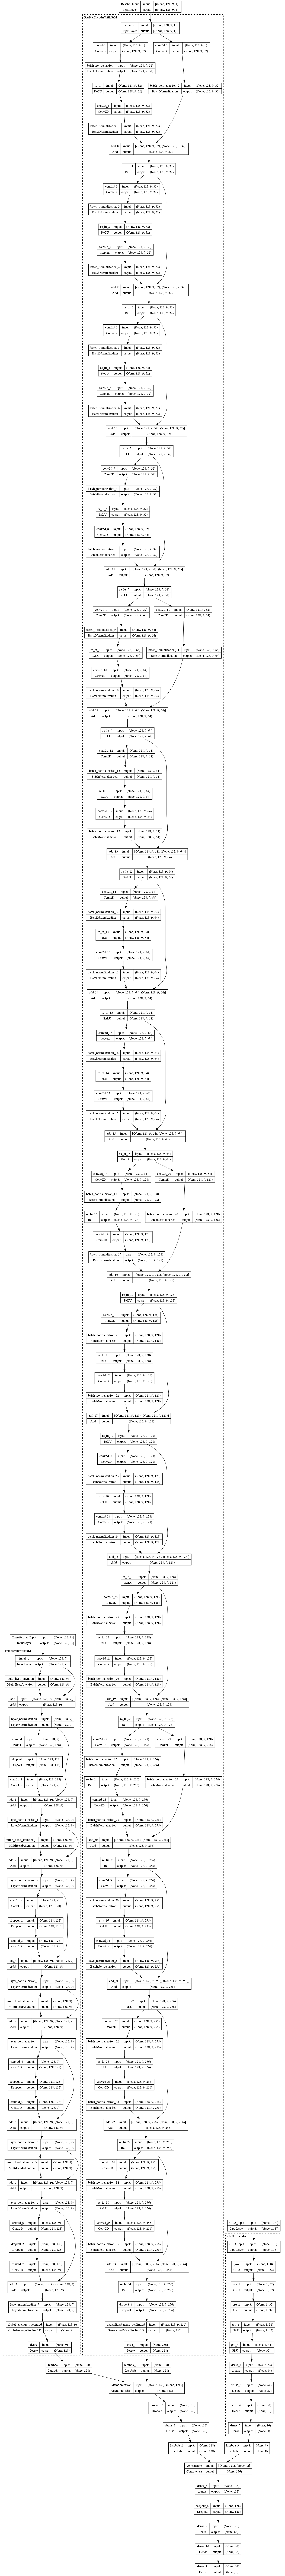

In [30]:
from tensorflow.keras.utils import plot_model

# 모델 시각화
plot_model(
    AF_GRU_model,                   # 학습에 사용된 모델
    to_file="model_plot.png",  # 저장할 파일 이름
    show_shapes=True,         # 각 레이어의 출력 텐서 모양 표시
    show_layer_names=True,    # 레이어 이름 표시
    expand_nested=True,       # 중첩된 모델 (서브모델) 시각화
    dpi=96                    # 해상도 설정
)

In [31]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_schedule(epoch, lr):
    if epoch < 5:
        return lr
    return lr * tf.math.exp(-0.05)  # 지수 감소

lr_scheduler = LearningRateScheduler(lr_schedule)

# ReduceLROnPlateau 설정
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # 검증 손실 기준으로 동작
    factor=0.5,          # 학습률 감소 비율 (50% 감소)
    patience = 5,          # 개선되지 않을 경우 5 Epoch 후 학습률 감소
    min_lr=1e-6          # 학습률의 하한선
)

# EarlyStopping 설정
early_stopping = EarlyStopping(
    monitor='val_loss',     # 검증 손실 기준으로 조기 종료
    patience=10,            # 개선되지 않을 경우 10 Epoch 후 종료
    restore_best_weights=True  # 가장 좋은 가중치로 복원
)


# 콜백 리스트
callbacks = [early_stopping, reduce_lr, lr_scheduler]

# 모델 학습
history = AF_GRU_model.fit(
    [trainX_transformer, trainX_resnet, X_train8],  # 입력 데이터
    trainy_one_hot,                       # 레이블
    validation_data=([valX_transformer, valX_resnet, X_val8],                # 검증 데이터 비율
    valy_one_hot),                 
    epochs=100,                          # 최대 Epoch 수
    batch_size=12,                       # 배치 사이즈
    callbacks=callbacks,                  # 콜백 리스트 추가
)

Epoch 1/100
255/255 [==============================] - 47s 127ms/step - loss: 0.0325 - accuracy: 0.8374 - val_loss: 0.0305 - val_accuracy: 0.6588 - lr: 0.0010
Epoch 2/100
255/255 [==============================] - 30s 120ms/step - loss: 0.0172 - accuracy: 0.8908 - val_loss: 0.0133 - val_accuracy: 0.9135 - lr: 0.0010
Epoch 3/100
255/255 [==============================] - 32s 124ms/step - loss: 0.0182 - accuracy: 0.8921 - val_loss: 0.0166 - val_accuracy: 0.8948 - lr: 0.0010
Epoch 4/100
255/255 [==============================] - 32s 124ms/step - loss: 0.0183 - accuracy: 0.8951 - val_loss: 0.0176 - val_accuracy: 0.9164 - lr: 0.0010
Epoch 5/100
255/255 [==============================] - 31s 121ms/step - loss: 0.0168 - accuracy: 0.9052 - val_loss: 0.0313 - val_accuracy: 0.7620 - lr: 0.0010
Epoch 6/100
255/255 [==============================] - 31s 121ms/step - loss: 0.0175 - accuracy: 0.9098 - val_loss: 0.0194 - val_accuracy: 0.8859 - lr: 9.5123e-04
Epoch 7/100
255/255 [=====================

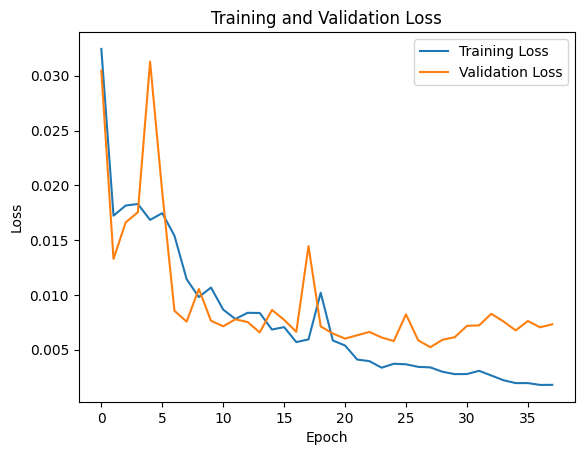

In [32]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

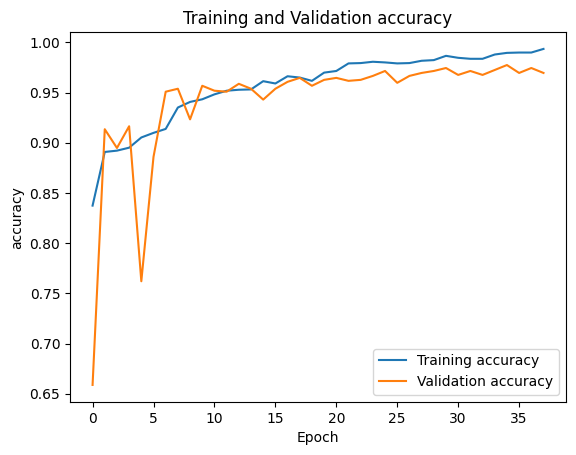

In [33]:
# Plot training and validation loss
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.title('Training and Validation accuracy')
plt.show()

49/49 [==============================] - 5s 83ms/step
Classification Report:
              precision    recall  f1-score   support

     SITTING       0.96      0.85      0.90       491
    STANDING       0.87      0.97      0.92       532
      LAYING       1.00      1.00      1.00       537

    accuracy                           0.94      1560
   macro avg       0.94      0.94      0.94      1560
weighted avg       0.94      0.94      0.94      1560

Test Accuracy: 0.94


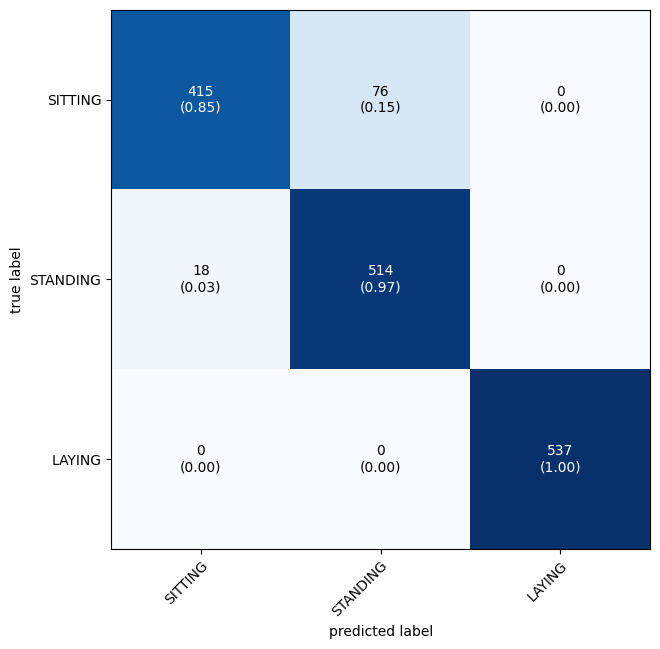

In [34]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np

# 예측 수행
predy = AF_GRU_model.predict([testX_transformer, testX_resnet, X_test8])
predy = np.argmax(predy, axis=-1)  # 가장 확률이 높은 클래스를 선택

# 테스트 라벨 (One-Hot Encoding → 정수형 라벨 변환)
testy = np.argmax(testy_one_hot, axis=-1)  # 테스트 레이블 변환

# 라벨 정의
LABELS = ['SITTING', 'STANDING', 'LAYING']

# 혼동 행렬 생성
cm = confusion_matrix(testy, predy)

# 혼동 행렬 시각화
plot_confusion_matrix(conf_mat=cm, class_names=LABELS, show_normed=True, figsize=(7,7))

# 성능 보고서 출력
print("Classification Report:")
print(classification_report(testy, predy, target_names=LABELS))

# 정확도 출력
accuracy = accuracy_score(testy, predy)
print(f"Test Accuracy: {accuracy:.2f}")

In [35]:
from sklearn.metrics import precision_score, recall_score, f1_score

print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))

[[415  76   0]
 [ 18 514   0]
 [  0   0 537]]
0.9397435897435897
0.9394098548510313
              precision    recall  f1-score   support

           0       0.96      0.85      0.90       491
           1       0.87      0.97      0.92       532
           2       1.00      1.00      1.00       537

    accuracy                           0.94      1560
   macro avg       0.94      0.94      0.94      1560
weighted avg       0.94      0.94      0.94      1560

